# 0 Load Packages

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.cm as cm
from scipy.cluster.hierarchy import linkage, dendrogram
from datetime import datetime
import xlrd
import os
import io
import requests
import statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from urllib.parse import urlparse
from requests import get
from math import pi

# 1 Read Data

In [2]:
# Read crime rates data
url_crime = "https://github.com/jyucing/QM_Individualwork/raw/main/data/crime.xlsx"
response = requests.get(url_crime)

with open("crime.xlsx", "wb") as file:
    file.write(response.content)

crime = pd.read_excel("crime.xlsx", sheet_name="Table C5", skiprows = 7)

## Check data
print(f"Data frame is {crime.shape[0]:,} x {crime.shape[1]}")
crime.head()

Data frame is 390 x 32


,Police Force Area code,Police Force Area name,Community Safety Partnership code,Community Safety Partnership name,Local Authority code,Local Authority name,Population figures (mid-2021) - rounded to 100,Household figures (mid-2020) - rounded to 100,Total recorded crime\n (excluding fraud),Violence against the person,...,Vehicle offences,Theft from the person,Bicycle theft,Shoplifting,All other theft offences,Criminal damage and arson,Drug offences,Possession of weapons offences,Public order offences,Miscellaneous crimes against society
0,E23000036,Avon and Somerset,NaN,NaN,NaN,NaN,1744800,737300,80.836477,29.888342,...,5.516984,0.520978,1.619675,6.313066,6.761257,7.987189,1.538864,0.544477,11.068355,1.409335
1,E23000036,Avon and Somerset,E22000001,Bath and North East Somerset,E06000022,Bath and North East Somerset,192400,79400,63.381197,22.980621,...,3.970419,0.426144,1.054967,5.550272,5.872479,5.612635,1.013392,0.358585,8.787931,1.106936
2,E23000036,Avon and Somerset,E22000002,"Bristol, City of",E06000023,"Bristol, City of",471100,195700,114.270977,37.962969,...,11.003636,1.101637,3.398307,8.140228,9.940206,11.092786,2.347612,0.806594,15.658531,1.702337
3,E23000036,Avon and Somerset,E22000003,North Somerset,E06000024,North Somerset,217400,96000,68.781365,28.100405,...,3.482077,0.27139,1.053363,4.254849,5.07362,7.401138,1.485747,0.611778,9.61366,1.264955
4,E23000036,Avon and Somerset,E22000369,Somerset,Combined Local Authorities,NaN,573100,247300,69.954058,28.756681,...,2.64692,0.300112,0.896847,5.634083,5.443896,7.056126,1.170787,0.462382,10.125297,1.359229


In [3]:
# Read rents data
url_rent = "https://github.com/jyucing/QM_Individualwork/raw/main/data/rent.xlsx"
response = requests.get(url_rent)

with open("rent.xlsx", "wb") as file:
    file.write(response.content)

rent = pd.read_excel("rent.xlsx")

## Check data
print(f"Data frame is {rent.shape[0]:,} x {rent.shape[1]}")
rent.head()
rent.sample(10)

Data frame is 314 x 9


,AREACD,AREANM,Room,Studio,One Bedroom,Two Bedrooms,Three Bedrooms,Four or more Bedrooms,All categories
305,E07000079,Cotswold,.,.,717,875,1100,1700,950
165,E07000095,Broxbourne,..,800,900,1114,1500,1800,1100
135,E08000031,Wolverhampton,350,475,475,673,795,1100,650
71,E08000036,Wakefield,368,463,500,600,725,975,625
81,E07000037,High Peak,390,..,523,675,800,973,625
190,E09000013,Hammersmith and Fulham,.,1056,1500,1950,2675,4250,1800
227,E06000038,Reading UA,550,695,895,1100,1250,1738,1006
31,E08000008,Tameside,520,385,550,650,800,1100,675
159,E07000072,Epping Forest,.,..,950,1250,1550,2300,1300
178,E07000146,King’s Lynn and West Norfolk,468,415,575,700,850,1258,730


In [4]:
# Read education data
edu = gpd.read_file("https://github.com/jyucing/QM_Individualwork/raw/main/data/educationPOI.gpkg", crs = 'EPSG:4326')
# Read transport data
transport = gpd.read_file("https://github.com/jyucing/QM_Individualwork/raw/main/data/transportPOI.gpkg", crs = 'EPSG:4326')
# Read cultural facilities data
cultural = gpd.read_file("https://github.com/jyucing/QM_Individualwork/raw/main/data/culturalPOI.gpkg", crs = 'EPSG:4326')

In [5]:
# Read London boroughs geo data
borough = gpd.read_file('http://data.insideairbnb.com/united-kingdom/england/london/2023-09-06/visualisations/neighbourhoods.geojson')

# 2 Data Wrangling

## 2.1 Data Cleaning

### 2.1.1 Drop NA values

In [6]:
# Crime data
crime = crime.dropna()

In [7]:
# Rent data
rent = rent.dropna()

### 2.1.2 Select & filter data

In [8]:
# Clean column names
def clean_columns(dataframe):
    for column in dataframe:
        dataframe.rename(columns = {column : column.lower().replace(" ", "_")},
                        inplace = 1)
    return dataframe.columns.to_list()

In [9]:
clean_columns(crime)

['police_force_area_code',
 'police_force_area_name',
 'community_safety_partnership_code',
 'community_safety_partnership_name',
 'local_authority_code',
 'local_authority_name',
 'population_figures_(mid-2021)_-_rounded_to_100',
 'household_figures_(mid-2020)_-_rounded_to_100',
 'total_recorded_crime\n_(excluding_fraud)',
 'violence_against_the_person',
 'homicide',
 'death_or_serious_injury_caused_by_illegal_driving',
 'violence_with_injury',
 'violence_without_injury',
 'stalking_and_harassment',
 'sexual_offences',
 'robbery',
 'theft_offences',
 'burglary',
 'residential_burglary_(per_1,000_population)',
 'residential_burglary_(per_1,000_household)',
 'non-residential_burglary',
 'vehicle_offences',
 'theft_from_the_person',
 'bicycle_theft',
 'shoplifting',
 'all_other_theft_offences',
 'criminal_damage_and_arson',
 'drug_offences',
 'possession_of_weapons_offences',
 'public_order_offences',
 'miscellaneous_crimes_against_society']

In [10]:
clean_columns(rent)

['areacd',
 'areanm',
 'room',
 'studio',
 'one_bedroom',
 'two_bedrooms',
 'three_bedrooms',
 'four_or_more_bedrooms',
 'all_categories']

In [11]:
# Crime data
crime_simplified = crime.loc[crime['local_authority_code'].str.startswith("E09"),['local_authority_code', 
                                                                                    'local_authority_name', 
                                                                                    'population_figures_(mid-2021)_-_rounded_to_100', 
                                                                                    'total_recorded_crime\n_(excluding_fraud)']]

## Check
crime_simplified.shape

(33, 4)

In [12]:
# Rent data
rent_simplified = rent.loc[rent['areacd'].str.startswith("E09"),['areacd', 'areanm','all_categories']]
## Check
rent_simplified.shape

(33, 3)

### 2.1.3 Spatial data

In [13]:
# Transfer CRS
borough = borough.to_crs(epsg=27700)
edu = edu.to_crs(epsg=27700)
transport = transport.to_crs(epsg=27700)
cultural = cultural.to_crs(epsg=27700)

In [14]:
for g in [edu,transport,cultural,borough]:
    print(g.crs)

EPSG:27700
EPSG:27700
EPSG:27700
EPSG:27700


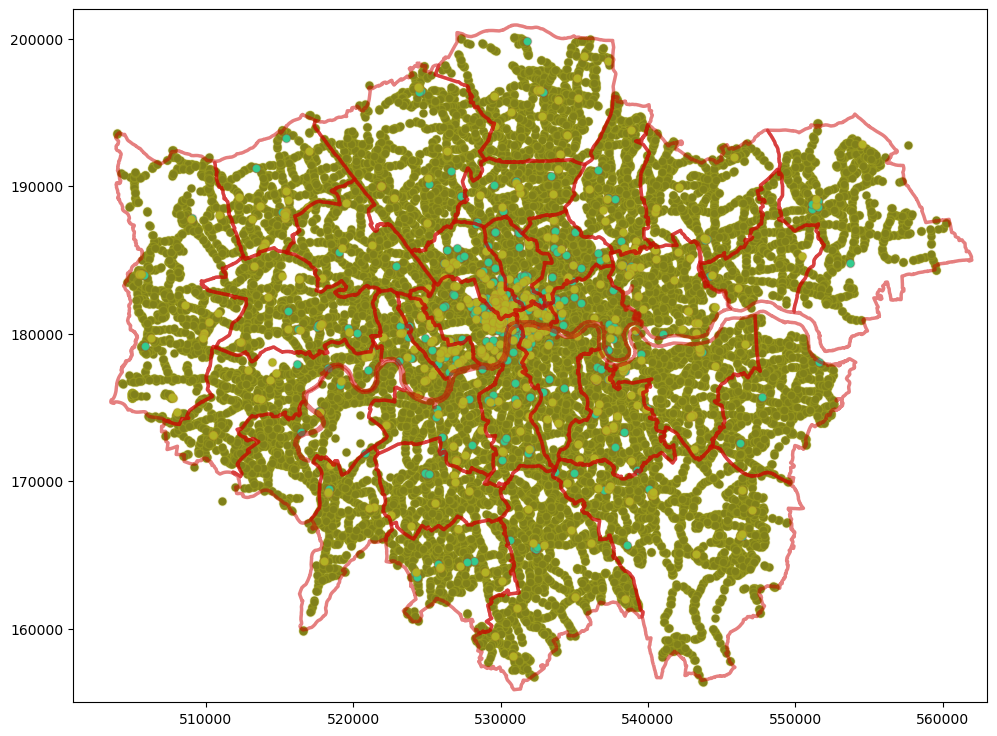

In [15]:
# Check
fig, ax = plt.subplots(1,1, figsize=(12,9))

# Plot all three GeoPackages to the same axes
transport.plot(edgecolor=(0.7, 0.7, 0.14, 0.25), facecolor=(0.5, 0.5, 0.1), ax=ax)
cultural.plot(edgecolor=(0.7, 0.1, 0.14, 0.25), facecolor=(0.2, 0.8, 0.56), ax=ax)
edu.plot(edgecolor=(0.7, 0.5, 0.14, 0.25), facecolor=(0.7, 0.7, 0.14), ax=ax)
borough.plot(edgecolor=(0.8, 0, 0, 0.5), facecolor='none', linewidth=2.5, ax=ax)

# Set the x and y limits
ax.set_xlim(501000,563000)
ax.set_ylim(155000,202000)

plt.show()

In [16]:
# number of POIs
print(len(edu))
print(len(transport))
print(len(cultural))

480
20964
293


In [17]:
# Spatial subset
# edu = edu[edu.intersects(borough)]
# transport = transport[transport.intersects(borough)]
# cultural = cultural[cultural.intersects(borough)]

In [18]:
# print(len(edu))
# print(len(transport))
# print(len(cultural))

### 2.1.4 Join Data

In [19]:
print(crime_simplified)
print(rent_simplified)
print(borough)

    local_authority_code    local_authority_name  \
26             E09000001          City of London   
210            E09000002    Barking and Dagenham   
211            E09000003                  Barnet   
212            E09000004                  Bexley   
213            E09000005                   Brent   
214            E09000006                 Bromley   
215            E09000007                  Camden   
216            E09000008                 Croydon   
217            E09000009                  Ealing   
218            E09000010                 Enfield   
219            E09000011               Greenwich   
220            E09000012                 Hackney   
221            E09000013  Hammersmith and Fulham   
222            E09000014                Haringey   
223            E09000015                  Harrow   
224            E09000016                Havering   
225            E09000017              Hillingdon   
226            E09000018                Hounslow   
227         

In [20]:
# Join data
borough_merge = borough.merge(crime_simplified, left_on='neighbourhood', right_on='local_authority_name', how='left').merge(rent_simplified, left_on='neighbourhood', right_on='areanm', how='left')

In [21]:
# Check
borough_merge

,neighbourhood,neighbourhood_group,geometry,local_authority_code,local_authority_name,population_figures_(mid-2021)_-_rounded_to_100,total_recorded_crime\n_(excluding_fraud),areacd,areanm,all_categories
0,Kingston upon Thames,NaN,"MULTIPOLYGON (((516403.207 160201.724, 516408....",E09000021,Kingston upon Thames,167800,74.533051,E09000021,Kingston upon Thames,1375
1,Croydon,NaN,"MULTIPOLYGON (((535011.098 159504.677, 535007....",E09000008,Croydon,390500,87.568437,E09000008,Croydon,1200
2,Bromley,NaN,"MULTIPOLYGON (((540375.488 157530.334, 540363....",E09000006,Bromley,329800,69.235667,E09000006,Bromley,1325
3,Hounslow,NaN,"MULTIPOLYGON (((521977.420 178100.131, 521969....",E09000018,Hounslow,287900,87.90373,E09000018,Hounslow,1400
4,Ealing,NaN,"MULTIPOLYGON (((510254.930 182881.758, 510251....",E09000009,Ealing,366100,84.039145,E09000009,Ealing,1500
5,Havering,NaN,"MULTIPOLYGON (((549895.918 181459.974, 549896....",E09000016,Havering,262000,76.459229,E09000016,Havering,1250
6,Hillingdon,NaN,"MULTIPOLYGON (((510601.311 191689.931, 510616....",E09000017,Hillingdon,304800,79.641198,E09000017,Hillingdon,1300
7,Harrow,NaN,"MULTIPOLYGON (((510601.311 191689.931, 510661....",E09000015,Harrow,261000,62.248311,E09000015,Harrow,1400
8,Brent,NaN,"MULTIPOLYGON (((525202.709 182512.864, 525183....",E09000005,Brent,338900,90.431904,E09000005,Brent,1500
9,Barnet,NaN,"MULTIPOLYGON (((524581.577 198355.591, 524595....",E09000003,Barnet,388600,72.720442,E09000003,Barnet,1500


## 2.2 Calculate indicators

In [22]:
# calculate the number and density (per 100000 population & per sq km) of places of interest in each borough
borough_merge['n_edu'] = borough_merge.geometry.apply(lambda x: len(edu[edu.intersects(x)]))
borough_merge['density_edu'] = borough_merge['n_edu'] / (borough_merge['population_figures_(mid-2021)_-_rounded_to_100']/1000)
borough_merge['density1_edu'] = borough_merge['n_edu'] / (borough_merge.geometry.area/1000000)

borough_merge['n_transport'] = borough_merge.geometry.apply(lambda x: len(transport[transport.intersects(x)]))
borough_merge['density_transport'] = borough_merge['n_transport'] / (borough_merge['population_figures_(mid-2021)_-_rounded_to_100']/1000)
borough_merge['density1_transport'] = borough_merge['n_transport'] / (borough_merge.geometry.area/1000000)

borough_merge['n_cultural'] = borough_merge.geometry.apply(lambda x: len(cultural[cultural.intersects(x)]))
borough_merge['density_cultural'] = borough_merge['n_cultural'] / (borough_merge['population_figures_(mid-2021)_-_rounded_to_100']/1000)
borough_merge['density1_cultural'] = borough_merge['n_cultural'] / (borough_merge.geometry.area/1000000)

In [23]:
borough_merge.columns.to_list()

['neighbourhood',
 'neighbourhood_group',
 'geometry',
 'local_authority_code',
 'local_authority_name',
 'population_figures_(mid-2021)_-_rounded_to_100',
 'total_recorded_crime\n_(excluding_fraud)',
 'areacd',
 'areanm',
 'all_categories',
 'n_edu',
 'density_edu',
 'density1_edu',
 'n_transport',
 'density_transport',
 'density1_transport',
 'n_cultural',
 'density_cultural',
 'density1_cultural']

In [24]:
# Clean merged dataframe
borough_merge1 = borough_merge.loc[:, ['neighbourhood', 
                                       'geometry', 
                                       'local_authority_code', 
                                       'population_figures_(mid-2021)_-_rounded_to_100', 
                                       'total_recorded_crime\n_(excluding_fraud)',
                                       'all_categories',
                                       'n_edu',
                                       'density_edu',
                                       'n_transport',
                                       'density_transport',
                                       'n_cultural',
                                       'density_cultural',
                                       'density1_edu',
                                       'density1_transport',
                                       'density1_cultural']]

In [25]:
# rename rents data column name
borough_merge1.rename(columns={'all_categories':'rent', 
                               'total_recorded_crime\n_(excluding_fraud)':'crime_rate(per_1000_pop)'}, inplace=True)

In [26]:
# Check
borough_merge1.sample(5)

,neighbourhood,geometry,local_authority_code,population_figures_(mid-2021)_-_rounded_to_100,crime_rate(per_1000_pop),rent,n_edu,density_edu,n_transport,density_transport,n_cultural,density_cultural,density1_edu,density1_transport,density1_cultural
29,Hackney,"MULTIPOLYGON (((531930.174 187801.858, 531937....",E09000012,260000,122.639985,1750,16,0.061538,497,1.911538,16,0.061538,0.839914,26.089818,0.839914
14,Lambeth,"MULTIPOLYGON (((530048.505 177893.582, 530050....",E09000022,317500,108.403832,1700,15,0.047244,656,2.066142,23,0.072441,0.559477,24.467797,0.857865
32,Barking and Dagenham,"MULTIPOLYGON (((543907.291 183199.243, 543906....",E09000002,218500,99.156195,1300,3,0.01373,405,1.853547,2,0.009153,0.083082,11.216122,0.055388
26,Camden,"MULTIPOLYGON (((528841.984 187218.150, 528836....",E09000007,210400,173.829555,1950,60,0.285171,502,2.385932,31,0.147338,2.753548,23.038022,1.422667
19,Richmond upon Thames,"MULTIPOLYGON (((516678.993 175383.844, 516680....",E09000027,195200,60.12334,1625,2,0.010246,573,2.935451,4,0.020492,0.034871,9.990466,0.069741


### Calculate crime rate of City of London

In [27]:
# 使用 loc 方法通过索引获取 'City of London' 的行数据
city_of_london_data = borough_merge1.loc[borough_merge1.neighbourhood == 'City of London']
city_of_london_data

,neighbourhood,geometry,local_authority_code,population_figures_(mid-2021)_-_rounded_to_100,crime_rate(per_1000_pop),rent,n_edu,density_edu,n_transport,density_transport,n_cultural,density_cultural,density1_edu,density1_transport,density1_cultural
24,City of London,"MULTIPOLYGON (((531146.858 180782.266, 531145....",E09000001,8600,[u1],1950,13,1.511628,158,18.372093,7,0.813953,4.476515,54.406879,2.410431


In [28]:
# Read crime cases data
year_month = ['2022-04','2022-05','2022-06','2022-07','2022-08','2022-09','2022-10','2022-11','2022-12','2023-01','2023-02','2023-03']
crime_CoL = {}

for ym in year_month:
    url_crime_CoL = f"https://github.com/jyucing/QM_Individualwork/raw/main/data/city_of_london_crime/{ym}/{ym}-city-of-london-street.csv"
    response = requests.get(url_crime_CoL)

    with open(f"{ym}-city-of-london-street.csv", "wb") as file:
        file.write(response.content)

    crime_CoL[ym] = pd.read_csv(f"{ym}-city-of-london-street.csv")

In [29]:
crime_CoL

{'2022-04':                                               Crime ID    Month  \
 0    288dbdaa9724c584c5a2e6efe5c0294ae10548490f3570...  2022-04   
 1                                                  NaN  2022-04   
 2                                                  NaN  2022-04   
 3                                                  NaN  2022-04   
 4    2bf5b4d9766e08247f29482a5552c2387162900f138ebc...  2022-04   
 ..                                                 ...      ...   
 649  46a6e8f538a10f420a6a92aec2b2f6bb3d4566e663ad21...  2022-04   
 650  9ef6760bdd7a511fab0b13d251cf8cf3f878adca68e1a5...  2022-04   
 651  0bda8840eaf9e95351a7624d820ed0b4da0795a6a725ba...  2022-04   
 652  abdd5d0c4da492f1f64775219ae11357879e1d7a7517fa...  2022-04   
 653  373e923a078c5dd1accf19fdaca93d08d69ca94a34f00e...  2022-04   
 
                Reported by           Falls within  Longitude   Latitude  \
 0    City of London Police  City of London Police  -0.111962  51.518494   
 1    City of Londo

In [30]:
# Convert crime_CoL to a dataframe
crime_CoL_combined = pd.concat(crime_CoL.values(), ignore_index=True)
print(f"There were {crime_CoL_combined.shape[0]} crime cases in City of London between 2022-04 and 2023-03.")

There were 8808 crime cases in City of London between 2022-04 and 2023-03.


In [31]:
# Add the crime rate of City of London to the borough df
borough_merge1.loc[borough_merge1.neighbourhood == 'City of London', 'crime_rate(per_1000_pop)'] = crime_CoL_combined.shape[0] / (borough_merge1.loc[borough_merge1.neighbourhood == 'City of London', 'population_figures_(mid-2021)_-_rounded_to_100']/10)

## 2.3 Standarlization

In [32]:
columns_to_normalize = ['crime_rate(per_1000_pop)',
                        'rent',
                        'density_edu',
                        'density_transport',
                        'density_cultural',
                        'density1_edu',
                        'density1_transport',
                        'density1_cultural']
print(borough_merge1[columns_to_normalize].dtypes)

crime_rate(per_1000_pop)     object
rent                          int64
density_edu                  object
density_transport            object
density_cultural             object
density1_edu                float64
density1_transport          float64
density1_cultural           float64
dtype: object


数据类型不能是object

In [83]:
# Transfer data type
for column in columns_to_normalize:
    borough_merge1[column].astype(int)

In [88]:
# 使用 apply 遍历每一列进行归一化操作
for column in columns_to_normalize:
    # 计算每一列的最小最大归一化值，并存储到新列中
    borough_merge1[f"min_max_norm_{column}"] = (borough_merge1[column] - borough_merge1[column].min()) / (borough_merge1[column].max() - borough_merge1[column].min())

In [89]:
# Check
borough_merge1

,neighbourhood,geometry,local_authority_code,population_figures_(mid-2021)_-_rounded_to_100,crime_rate(per_1000_pop),rent,n_edu,density_edu,n_transport,density_transport,...,min_max_norm_density_edu,min_max_norm_density_transport,min_max_norm_density_cultural,min_max_norm_density1_edu,min_max_norm_density1_transport,min_max_norm_density1_cultural,min_max_norm_crime_rate_reverse,min_max_norm_rent_reverse,KMeans,cluster
0,Kingston upon Thames,"MULTIPOLYGON (((516403.207 160201.724, 516408....",E09000021,167800,74.533051,1375,6,0.035757,491,2.926103,...,0.023655,0.079361,0.014822,0.035970,0.139098,0.022890,0.838916,0.849057,0,0
1,Croydon,"MULTIPOLYGON (((535011.098 159504.677, 535007....",E09000008,390500,87.568437,1200,10,0.025608,1139,2.916773,...,0.016941,0.078805,0.008542,0.025826,0.138916,0.013369,0.806255,0.981132,0,0
2,Bromley,"MULTIPOLYGON (((540375.488 157530.334, 540363....",E09000006,329800,69.235667,1325,14,0.04245,1281,3.884172,...,0.028082,0.136466,0.018964,0.020831,0.042118,0.008680,0.852189,0.886792,0,0
3,Hounslow,"MULTIPOLYGON (((521977.420 178100.131, 521969....",E09000018,287900,87.90373,1400,11,0.038208,729,2.532129,...,0.025276,0.055879,0.009891,0.043937,0.136129,0.019120,0.805415,0.830189,0,0
4,Ealing,"MULTIPOLYGON (((510254.930 182881.758, 510251....",E09000009,366100,84.039145,1500,12,0.032778,819,2.237094,...,0.021684,0.038294,0.019739,0.048260,0.171829,0.049526,0.815098,0.754717,0,0
5,Havering,"MULTIPOLYGON (((549895.918 181459.974, 549896....",E09000016,262000,76.459229,1250,3,0.01145,732,2.793893,...,0.007575,0.071481,0.016314,0.005965,0.000000,0.007790,0.834090,0.943396,0,0
6,Hillingdon,"MULTIPOLYGON (((510601.311 191689.931, 510616....",E09000017,304800,79.641198,1300,15,0.049213,922,3.024934,...,0.032556,0.085252,0.004877,0.028960,0.030347,0.000000,0.826117,0.905660,0,0
7,Harrow,"MULTIPOLYGON (((510601.311 191689.931, 510661....",E09000015,261000,62.248311,1400,14,0.05364,480,1.83908,...,0.035485,0.014571,0.006921,0.061971,0.062561,0.014057,0.869696,0.830189,0,0
8,Brent,"MULTIPOLYGON (((525202.709 182512.864, 525183....",E09000005,338900,90.431904,1500,5,0.014754,652,1.923871,...,0.00976,0.019625,0.0,0.025835,0.178848,0.008526,0.799081,0.754717,0,0
9,Barnet,"MULTIPOLYGON (((524581.577 198355.591, 524595....",E09000003,388600,72.720442,1500,8,0.020587,1027,2.64282,...,0.013619,0.062477,0.011804,0.020601,0.111154,0.018132,0.843458,0.754717,0,0


In [36]:
# Check data type
for column in columns_to_normalize:
    print(borough_merge1[f"min_max_norm_{column}"].dtypes)

object
float64
object
object
object
float64
float64
float64


In [37]:
# Transfer data type
for column in columns_to_normalize:
    borough_merge1[f"min_max_norm_{column}"] = pd.to_numeric(borough_merge1[f"min_max_norm_{column}"], errors='coerce')

## 2.4 Retrogradation

In [38]:
# 逆向化 Min-Max 标准化后的数据
borough_merge1['min_max_norm_crime_rate_reverse'] = 1 - borough_merge1['min_max_norm_crime_rate(per_1000_pop)']
borough_merge1['min_max_norm_rent_reverse'] = 1 - borough_merge1['min_max_norm_rent']

In [39]:
# Check
borough_merge1.loc[:,['min_max_norm_crime_rate(per_1000_pop)','min_max_norm_crime_rate_reverse','min_max_norm_rent_reverse','min_max_norm_rent']]

,min_max_norm_crime_rate(per_1000_pop),min_max_norm_crime_rate_reverse,min_max_norm_rent_reverse,min_max_norm_rent
0,0.161084,0.838916,0.849057,0.150943
1,0.193745,0.806255,0.981132,0.018868
2,0.147811,0.852189,0.886792,0.113208
3,0.194585,0.805415,0.830189,0.169811
4,0.184902,0.815098,0.754717,0.245283
5,0.165910,0.834090,0.943396,0.056604
6,0.173883,0.826117,0.905660,0.094340
7,0.130304,0.869696,0.830189,0.169811
8,0.200919,0.799081,0.754717,0.245283
9,0.156542,0.843458,0.754717,0.245283


## 2.5 Multicollinearity

创建一个包含常数列的副本
subset = borough_merge1[columns_to_normalize[0:5]]
subset = add_constant(subset)

计算VIF（方差膨胀因子）
vif_data = pd.Series([variance_inflation_factor(subset.values, i) for i in range(subset.shape[1])], index=subset.columns)
print(vif_data)

In [40]:
columns_to_calculate = ['min_max_norm_crime_rate_reverse',
                        'min_max_norm_rent_reverse',
                        'min_max_norm_density1_edu',
                        'min_max_norm_density1_transport',
                        'min_max_norm_density1_cultural']

In [41]:
# 创建一个包含常数列的副本
subset1 = borough_merge1[columns_to_calculate]
subset1 = add_constant(subset1)

# 计算VIF（方差膨胀因子）
vif_data1 = pd.Series([variance_inflation_factor(subset1.values, i) for i in range(subset1.shape[1])], index=subset1.columns)
print(vif_data1)

const                              51.683870
min_max_norm_crime_rate_reverse     2.956927
min_max_norm_rent_reverse           3.401171
min_max_norm_density1_edu           6.695482
min_max_norm_density1_transport     8.539705
min_max_norm_density1_cultural     13.759305
dtype: float64


# 3 Descriptive Analysis

## 3.1 Top 5 & Bottom 5

In [42]:
# Create empty dictionaries to store top5 and bottom5
top5 = {}
bottom5 = {}

# Find the top 5 and Bottom 5 boroughs for each column
for column in columns_to_calculate:
    # Store top 5 boroughs for each column in the top5 dictionary
    top5[column] = borough_merge1.nlargest(5, column)['neighbourhood']

for column in columns_to_calculate:
    # Store bottom 5 boroughs for each column in the bottom5 dictionary
    bottom5[column] = borough_merge1.nsmallest(5, column)['neighbourhood']

# Display dictionaries
print("Top 5 Boroughs for each column:")
print(top5)

Top 5 Boroughs for each column:
{'min_max_norm_crime_rate_reverse': 24          City of London
19    Richmond upon Thames
7                   Harrow
13                  Sutton
20                  Merton
Name: neighbourhood, dtype: object, 'min_max_norm_rent_reverse': 13        Sutton
1        Croydon
5       Havering
6     Hillingdon
18        Bexley
Name: neighbourhood, dtype: object, 'min_max_norm_density1_edu': 24            City of London
25               Westminster
26                    Camden
23    Kensington and Chelsea
29                   Hackney
Name: neighbourhood, dtype: object, 'min_max_norm_density1_transport': 24    City of London
25       Westminster
28         Islington
29           Hackney
27     Tower Hamlets
Name: neighbourhood, dtype: object, 'min_max_norm_density1_cultural': 24    City of London
25       Westminster
26            Camden
28         Islington
14           Lambeth
Name: neighbourhood, dtype: object}


In [43]:
print("\nBottom 5 Boroughs for each column:")
print(bottom5)


Bottom 5 Boroughs for each column:
{'min_max_norm_crime_rate_reverse': 25               Westminster
26                    Camden
23    Kensington and Chelsea
28                 Islington
29                   Hackney
Name: neighbourhood, dtype: object, 'min_max_norm_rent_reverse': 23    Kensington and Chelsea
25               Westminster
24            City of London
26                    Camden
15                 Southwark
Name: neighbourhood, dtype: object, 'min_max_norm_density1_edu': 18                  Bexley
5                 Havering
19    Richmond upon Thames
32    Barking and Dagenham
9                   Barnet
Name: neighbourhood, dtype: object, 'min_max_norm_density1_transport': 5                 Havering
6               Hillingdon
2                  Bromley
7                   Harrow
19    Richmond upon Thames
Name: neighbourhood, dtype: object, 'min_max_norm_density1_cultural': 6     Hillingdon
12     Redbridge
5       Havering
8          Brent
2        Bromley
Name: neighb

## 3.2 Summary

In [44]:
statistics = {
    'Mean': borough_merge1[columns_to_calculate].mean(),
    'Standard Deviation': borough_merge1[columns_to_calculate].std(),
    'Coefficient of Variation': borough_merge1[columns_to_calculate].std() / borough_merge1[columns_to_calculate].mean(),
    'Median': borough_merge1[columns_to_calculate].median(),
}

statistics_df = pd.DataFrame(statistics)
statistics_df

,Mean,Standard Deviation,Coefficient of Variation,Median
min_max_norm_crime_rate_reverse,0.773050,0.157300,0.203480,0.805415
min_max_norm_rent_reverse,0.701018,0.239596,0.341783,0.754717
min_max_norm_density1_edu,0.143618,0.224181,1.560955,0.060378
min_max_norm_density1_transport,0.225899,0.188770,0.835640,0.178848
min_max_norm_density1_cultural,0.161493,0.257060,1.591775,0.035463


In [103]:
statistics = {
    'Mean': borough_merge1[columns_to_normalize].mean(),
    'Standard Deviation': borough_merge1[columns_to_normalize].std(),
    'Coefficient of Variation': borough_merge1[columns_to_normalize].std() *100 / borough_merge1[columns_to_normalize].mean(),
    'Median': borough_merge1[columns_to_normalize].median(),
}

statistics_df = pd.DataFrame(statistics)
statistics_df

,Mean,Standard Deviation,Coefficient of Variation,Median
crime_rate(per_1000_pop),100.821133,62.781151,62.269833,87.90373
rent,1571.151515,317.465069,20.205885,1500.0
density_edu,0.103119,0.262367,254.430443,0.039442
density_transport,2.836236,2.835699,99.981038,2.33489
density_cultural,0.059792,0.142505,238.335107,0.019084
density1_edu,0.642907,1.003549,156.095497,0.270285
density1_transport,17.333907,9.0405,52.155006,15.080575
density1_cultural,0.411008,0.61296,149.135853,0.110491


In [45]:
# Check
# borough_merge1.loc[:, ['crime_rate(per_1000_pop)', 'rent', 'density1_edu', 'density1_transport', 'density1_cultural']]

# 4 Outliers

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

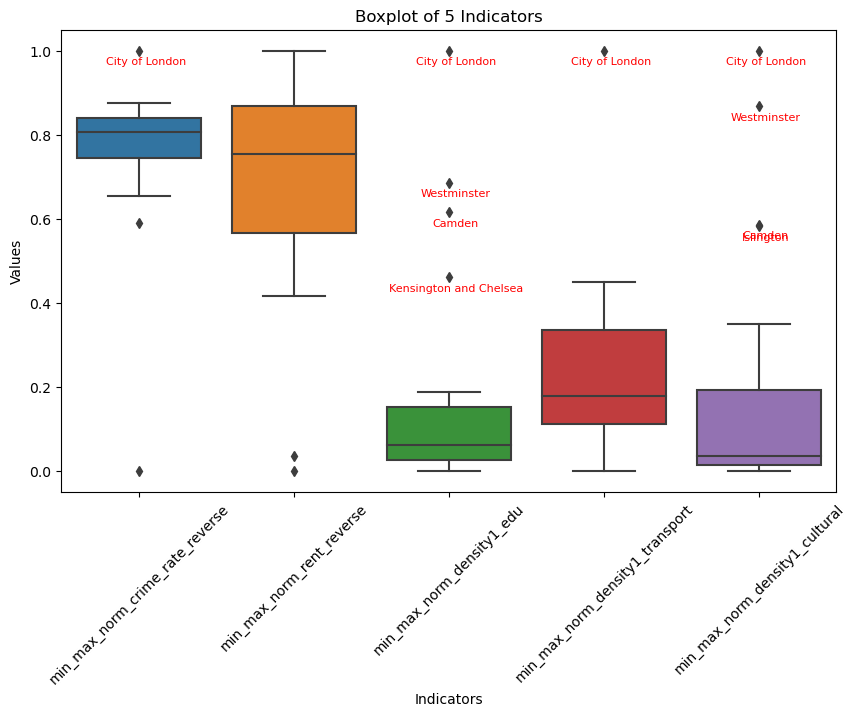

In [46]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=borough_merge1[columns_to_calculate])
plt.xticks(rotation=45)  # 如果列名较长，可以旋转x轴标签
plt.title('Boxplot of 5 Indicators')
plt.xlabel('Indicators')
plt.ylabel('Values')

# 标识异常值
for i, col in enumerate(columns_to_calculate):
    outliers = borough_merge1[col][borough_merge1[col] > borough_merge1[col].quantile(0.75) + 1.5 * (borough_merge1[col].quantile(0.75) - borough_merge1[col].quantile(0.25))]
    for outlier in outliers:
        borough_name = borough_merge1.loc[borough_merge1[col] == outlier, 'neighbourhood'].values[0]
        plt.annotate(f'{borough_name}', (i, outlier), textcoords="offset points", xytext=(5,-10), ha='center', fontsize=8, color='red')

plt.show()

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

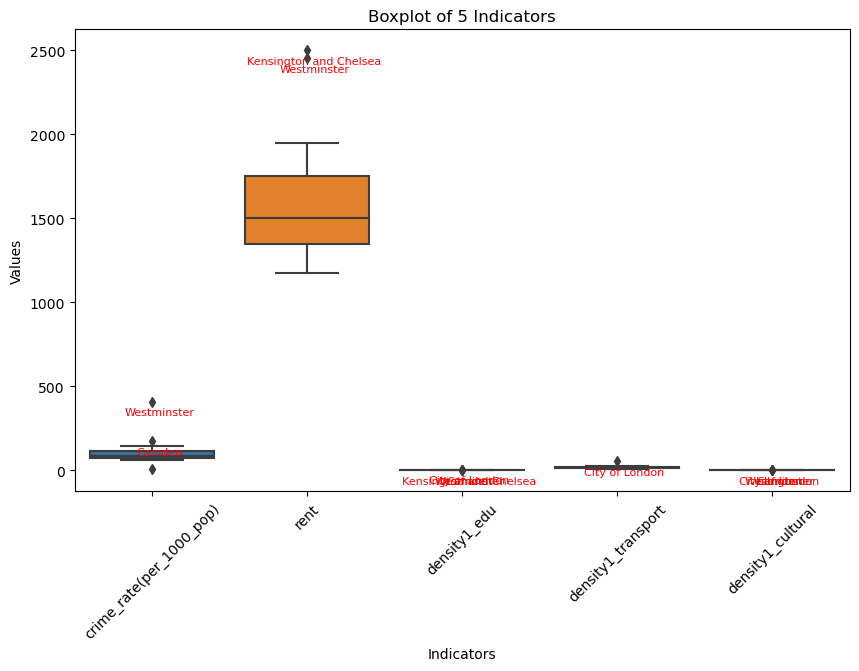

In [47]:
columns_raw = ['crime_rate(per_1000_pop)',
                        'rent',
                        'density1_edu',
                        'density1_transport',
                        'density1_cultural']

plt.figure(figsize=(10, 6))
sns.boxplot(data=borough_merge1[columns_raw])
plt.xticks(rotation=45)  # 如果列名较长，可以旋转x轴标签
plt.title('Boxplot of 5 Indicators')
plt.xlabel('Indicators')
plt.ylabel('Values')

# 标识异常值
for i, col in enumerate(columns_raw):
    outliers = borough_merge1[col][borough_merge1[col] > borough_merge1[col].quantile(0.75) + 1.5 * (borough_merge1[col].quantile(0.75) - borough_merge1[col].quantile(0.25))]
    for outlier in outliers:
        borough_name = borough_merge1.loc[borough_merge1[col] == outlier, 'neighbourhood'].values[0]
        plt.annotate(f'{borough_name}', (i, outlier), textcoords="offset points", xytext=(5,-10), ha='center', fontsize=8, color='red')

plt.show()

# 5 Clustering

In [48]:
def plt_ldn(w, b):
    """
    Creates a new figure of a standard size with the 
    water (w) and boundary (b) layers set up for easy
    plotting. Right now this function assumes that you're
    looking at London, but you could parameterise it in
    other ways ot allow it to work for other areas.
    
    w: a water layer for London
    b: a borough (or other) boundary layer for London
    """
    fig, ax = plt.subplots(1, figsize=(14, 12))
    w.plot(ax=ax, color='#79aef5', zorder=2)
    b.plot(ax=ax, edgecolor='#cc2d2d', facecolor='None', zorder=3)
    ax.set_xlim([502000,563000])
    ax.set_ylim([155000,201500])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    return fig, ax

def cache_data(src:str, dest:str) -> str:
    """Downloads and caches a remote file locally.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dest : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    # Check if dest+filename does *not* exist -- 
    # that would mean we have to download it!
    if not os.path.isfile(dfn) or os.path.getsize(dfn) < 1:
        
        print(f"{dfn} not found, downloading!")

        # Convert the path back into a list (without)
        # the filename -- we need to check that directories
        # exist first.
        path = os.path.split(dest)
        
        # Create any missing directories in dest(ination) path
        # -- os.path.join is the reverse of split (as you saw above)
        # but it doesn't work with lists... so I had to google how
        # to use the 'splat' operator! os.makedirs creates missing
        # directories in a path automatically.
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        # Download and write the file
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print('Done downloading...')

    else:
        print(f"Found {dfn} locally!")

    return dfn
    
spath = 'https://github.com/jreades/fsds/blob/master/data/src/' # source path
ddir  = os.path.join('data','geo') # destination directory
water = gpd.read_file( cache_data(spath+'Water.gpkg?raw=true', ddir) )
boros = gpd.read_file( cache_data(spath+'Boroughs.gpkg?raw=true', ddir) )

Found data/geo/Water.gpkg locally!
Found data/geo/Boroughs.gpkg locally!


## 5.1 Determine the best number of clusters

In [49]:
%%time 

# Adapted from: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

x = []
y = []

# For resolutions of 'k' in the range 2..40
for k in range(2,32):
    
    #############
    # Do the clustering using the main columns
    kmeans = KMeans(n_clusters=k, n_init=25, random_state=42).fit(borough_merge1[columns_to_calculate])
    
    # Calculate the overall silhouette score
    silhouette_avg = silhouette_score(borough_merge1[columns_to_calculate], kmeans.labels_)
    
    y.append(k)
    x.append(silhouette_avg)
    
    print('.', end='')

..............................CPU times: user 11.6 s, sys: 192 ms, total: 11.8 s
Wall time: 1.22 s



Largest silhouette score was 0.6606 for k=2


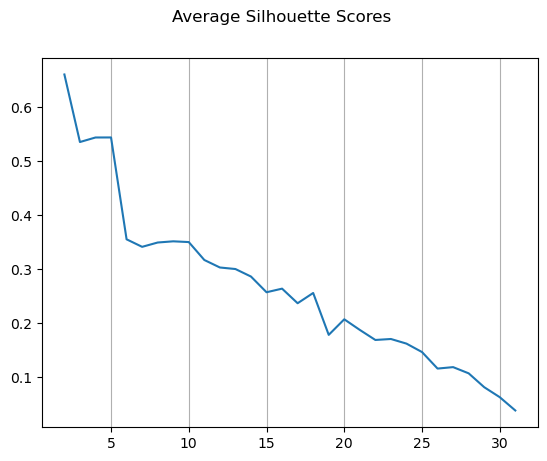

In [50]:
print()
print(f"Largest silhouette score was {max(x):6.4f} for k={y[x.index(max(x))]}")

plt.plot(y, x)
plt.gca().xaxis.grid(True);
plt.gcf().suptitle("Average Silhouette Scores");

当k=2时，聚类太极端了，3还不错

In [51]:
c_nm   = 'KMeans' # Clustering name
k_pref = 3 # Number of clusters

kmeans = KMeans(n_clusters=k_pref, n_init=25, random_state=42).fit(borough_merge1[columns_to_calculate]) # The process

print(kmeans.labels_) # The results

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 2 2 1 1 1 1 2 2 2 0 0 0]


/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


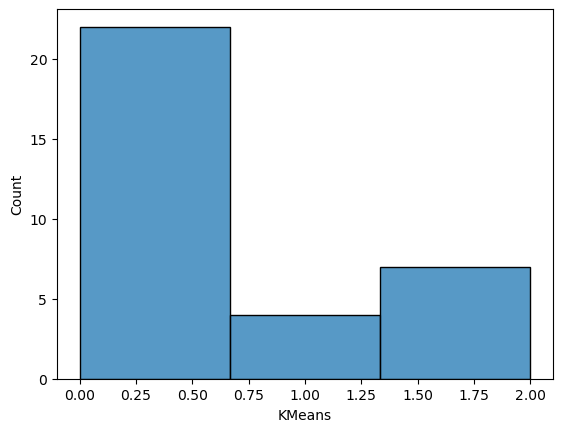

In [52]:
borough_merge1[c_nm] = pd.Series(kmeans.labels_, index=borough_merge1[columns_to_calculate].index)

sns.histplot(data=borough_merge1, x=c_nm, bins=k_pref);

## 5.3 Plot the Cluster Map

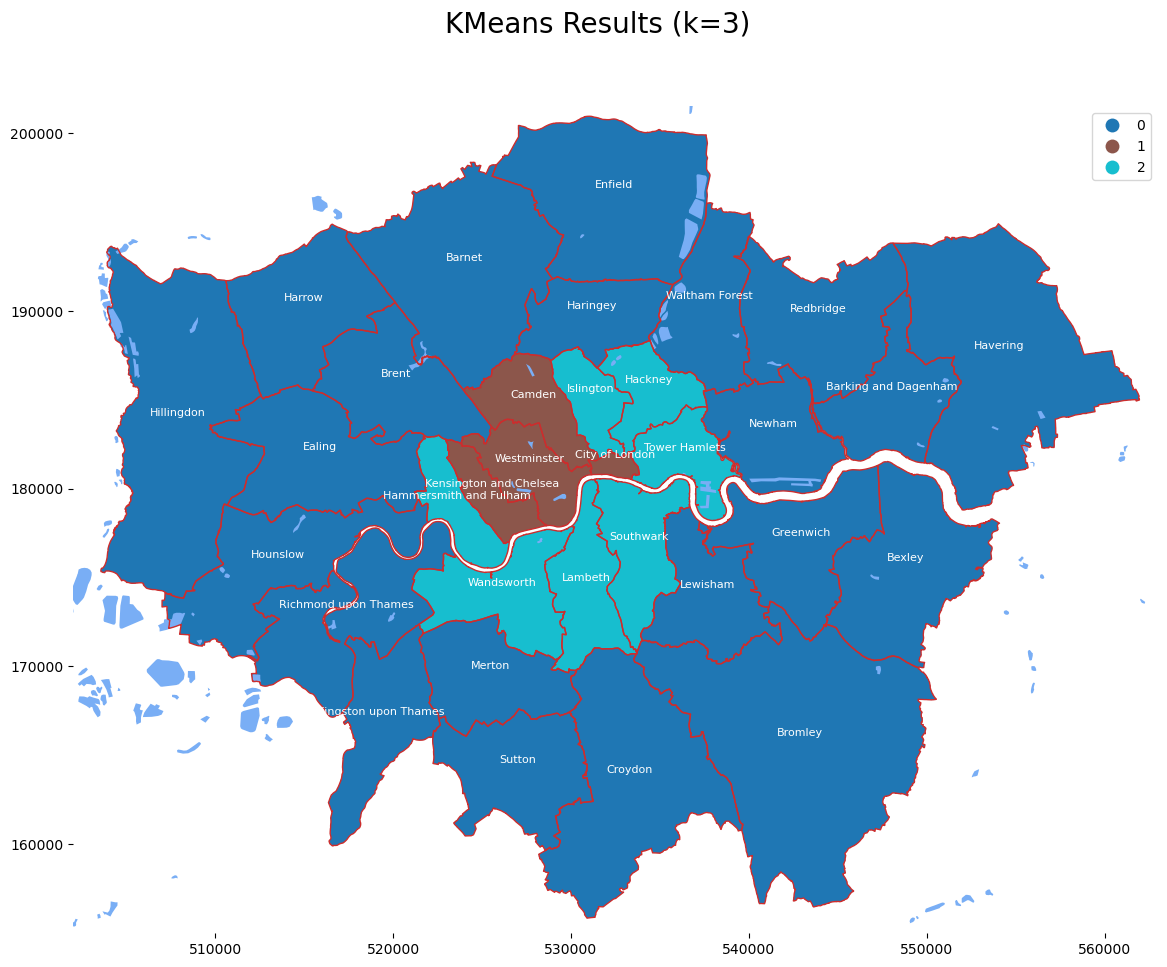

In [53]:
from shapely.geometry import Point

# Assuming you have the 'borough_merge1' GeoDataFrame with the column 'geometry' and 'borough_name'
fig, ax = plt_ldn(water, boros)
fig.suptitle(f"{c_nm} Results (k={k_pref})", fontsize=20, y=0.92)
borough_merge1.plot(column=c_nm, ax=ax, linewidth=0, zorder=0, categorical=True, legend=True)

# Annotate each borough with its name
for idx, row in borough_merge1.iterrows():
    # Calculate the centroid of the borough geometry
    centroid = row['geometry'].centroid
    
    # Split the borough name into multiple lines if it's too long
    lines = row['neighbourhood'].split('\n')
    
    # Calculate the offset for vertical spacing between lines
    line_offset = len(lines) * 6
    
    # Annotate each line with the borough name at the centroid
    for i, line in enumerate(lines):
        ax.annotate(line, xy=(centroid.x, centroid.y), xytext=(0, line_offset + i * 12), textcoords="offset points", ha='center', fontsize=8, color='white')

plt.show()

k_pref=2

#############
 Do the clustering using the main columns
kmeans = KMeans(n_clusters=k_pref, n_init=25, random_state=42).fit(borough_merge1[columns_to_calculate])

 Convert to a series
s = pd.Series(kmeans.labels_, index=borough_merge1[columns_to_calculate].index, name=c_nm)

 We do this for plotting
borough_merge1[c_nm] = s
    
 Calculate the overall silhouette score
silhouette_avg = silhouette_score(borough_merge1[columns_to_calculate], kmeans.labels_)

 Calculate the silhouette values
sample_silhouette_values = silhouette_samples(borough_merge1[columns_to_calculate], kmeans.labels_)

#############
 Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(9, 5)

 The 1st subplot is the silhouette plot
 The silhouette coefficient can range from -1, 1
ax1.set_xlim([-1.0, 1.0]) # Changed from -0.1, 1
    
 The (n_clusters+1)*10 is for inserting blank space between silhouette
 plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, borough_merge1[columns_to_calculate].shape[0] + (k_pref + 1) * 10])
    
y_lower = 10
    
 For each of the clusters...
for i in range(k_pref):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[kmeans.labels_ == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
        
    # Set the color ramp
    color = plt.cm.Spectral(i/k_pref)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=0.5)

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks(np.arange(-1.0, 1.1, 0.2)) # Was: [-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1]

    # 2nd Plot showing the actual clusters formed --
    # we can only do this for the first two dimensions
    # so we may not see fully what is causing the 
    # resulting assignment
    colors = plt.cm.Spectral(kmeans.labels_.astype(float) / k_pref)
    ax2.scatter(borough_merge1[columns_to_calculate][borough_merge1[columns_to_calculate].columns[0]], borough_merge1[columns_to_calculate][borough_merge1[columns_to_calculate].columns[1]], 
                marker='.', s=30, lw=0, alpha=0.7, c=colors)

    # Labeling the clusters
    centers = kmeans.cluster_centers_
    
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("Visualization of the clustered data")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(("Silhouette results for KMeans clustering "
                "with %d clusters" % k_pref),
                fontsize=14, fontweight='bold')

plt.show()

fig, ax = plt_ldn(water, boros)
fig.suptitle(f"{c_nm} Results (k={k_pref})", fontsize=20, y=0.92)
borough_merge1.plot(column=c_nm, ax=ax, linewidth=0, zorder=0, categorical=True, legend=True);

## 5.4 Mean of clusters

### 5.4.1 Calculate the mean and the rank

In [54]:
# 获取每个聚类的街区
cluster_labels = kmeans.labels_
borough_merge1['cluster'] = cluster_labels

# 根据聚类标签分组数据
grouped_data = borough_merge1.groupby('cluster')

# 计算每个聚类的指标均值
cluster_means = grouped_data[columns_to_calculate].mean()
cluster_means

,min_max_norm_crime_rate_reverse,min_max_norm_rent_reverse,min_max_norm_density1_edu,min_max_norm_density1_transport,min_max_norm_density1_cultural
cluster,,,,,
0,0.820541,0.837118,0.044481,0.128389,0.025282
1,0.561334,0.216038,0.690468,0.541489,0.697042
2,0.744774,0.550404,0.142703,0.352021,0.283555


In [55]:
# Renames
features = ['crime_rate_r', 'rents_r','d_edu','d_transport','d_cultural']

for ci in range(0, 5):
    col_name = cluster_means.columns[ci]
    new_col_name = features[ci]
    cluster_means.rename(columns={col_name: new_col_name}, inplace=True)

cluster_means

,crime_rate_r,rents_r,d_edu,d_transport,d_cultural
cluster,,,,,
0,0.820541,0.837118,0.044481,0.128389,0.025282
1,0.561334,0.216038,0.690468,0.541489,0.697042
2,0.744774,0.550404,0.142703,0.352021,0.283555


### 5.4.2 Radar Chart

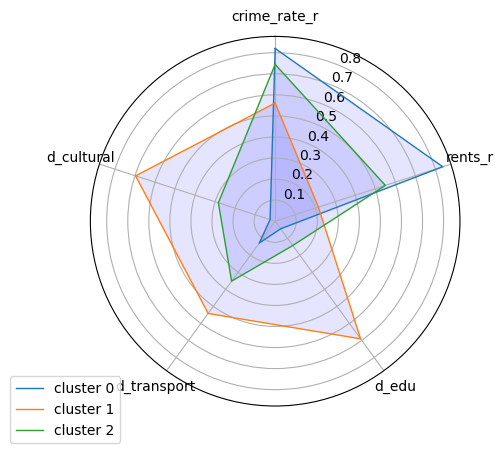

In [56]:
# ---------- 步骤1 创建背景

# number of variable
# 变量类别
categories = list(cluster_means)[0:]
# 变量类别个数
N = len(categories)

# 设置每个点的角度值
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Initialise the spider plot
# 初始化极坐标网格
ax = plt.subplot(111, polar=True)

# If you want the first axis to be on top:
# 设置角度偏移
ax.set_theta_offset(pi / 2)
# 设置顺时针还是逆时针，1或者-1
ax.set_theta_direction(-1)

# Draw one axe per variable + add labels labels yet
# 设置x轴的标签
plt.xticks(angles[:-1], categories)


# ---------- 步骤2 绘制数据

# 单独绘制每一组数据
for i in range(0,3):
    values = cluster_means.iloc[i].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=f"cluster {i}")
    ax.fill(angles, values, 'b', alpha=0.1)


# Add legend
# 添加图例
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1));

In [57]:
# Rank
# 计算每列的排名并将结果存储在新的列中
for column in cluster_means.columns:
    rank_column = f'{column}_rank'
    cluster_means[rank_column] = cluster_means[column].rank(ascending=False)

cluster_means['boro'] = grouped_data['neighbourhood'].apply(list)

# 打印带有排名的 DataFrame
cluster_means

,crime_rate_r,rents_r,d_edu,d_transport,d_cultural,crime_rate_r_rank,rents_r_rank,d_edu_rank,d_transport_rank,d_cultural_rank,boro
cluster,,,,,,,,,,,
0,0.820541,0.837118,0.044481,0.128389,0.025282,1.0,1.0,3.0,3.0,3.0,"[Kingston upon Thames, Croydon, Bromley, Houns..."
1,0.561334,0.216038,0.690468,0.541489,0.697042,3.0,3.0,1.0,1.0,1.0,"[Kensington and Chelsea, City of London, Westm..."
2,0.744774,0.550404,0.142703,0.352021,0.283555,2.0,2.0,2.0,2.0,2.0,"[Lambeth, Southwark, Wandsworth, Hammersmith a..."


In [58]:
print(cluster_means['boro'][0])
print(cluster_means['boro'][1])
print(cluster_means['boro'][2])

['Kingston upon Thames', 'Croydon', 'Bromley', 'Hounslow', 'Ealing', 'Havering', 'Hillingdon', 'Harrow', 'Brent', 'Barnet', 'Enfield', 'Waltham Forest', 'Redbridge', 'Sutton', 'Lewisham', 'Greenwich', 'Bexley', 'Richmond upon Thames', 'Merton', 'Haringey', 'Newham', 'Barking and Dagenham']
['Kensington and Chelsea', 'City of London', 'Westminster', 'Camden']
['Lambeth', 'Southwark', 'Wandsworth', 'Hammersmith and Fulham', 'Tower Hamlets', 'Islington', 'Hackney']


'Central Activities Zone'：City of London, Westminster, Camden, Islington, Hackney, Tower Hamlets, Southwark, Lambeth, Kensington & Chelsea, Wandsworth

# 6 ANOVA

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

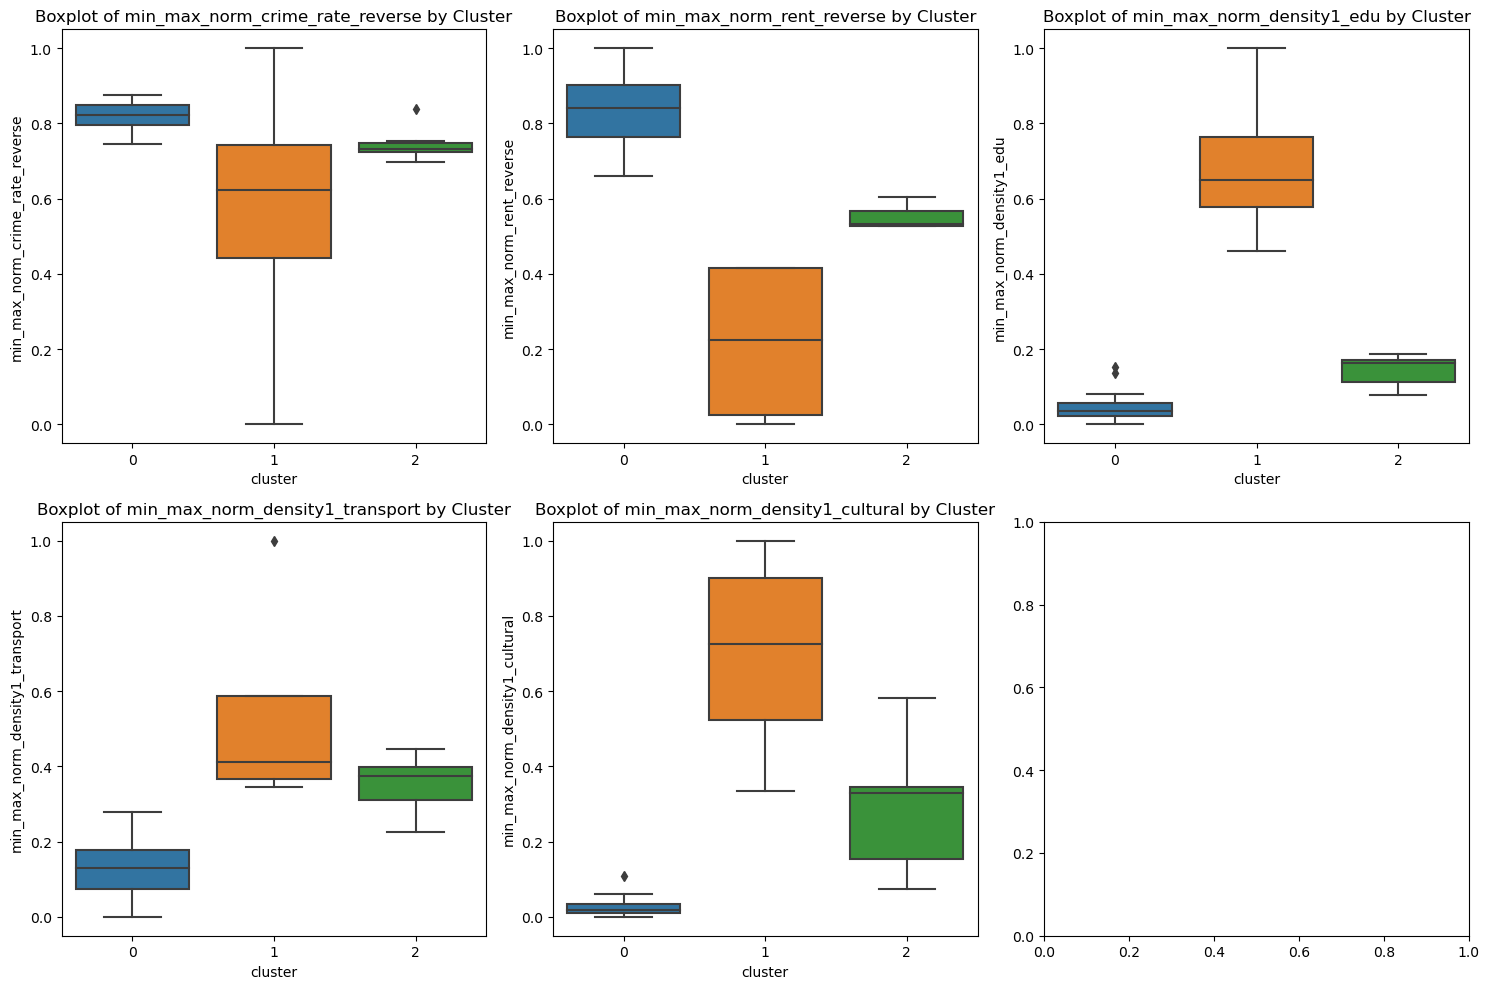

In [59]:
# Visualize the distribution of each feature for each DBSCAN cluster using box plots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

for i, feature in enumerate(columns_to_calculate):
    row, col = divmod(i, 3)
    ax = axes[row, col]
    sns.boxplot(x=borough_merge1['cluster'], y=feature, data=borough_merge1[columns_to_calculate], ax=ax)
    ax.set_title(f'Boxplot of {feature} by Cluster')

plt.tight_layout()
plt.show()

In [60]:
import scipy.stats as stats

f_val = []
p_val = []

for j in columns_to_calculate:
    result = stats.f_oneway(borough_merge1[borough_merge1['cluster'] == 0][j],
                             borough_merge1[borough_merge1['cluster'] == 1][j],
                             borough_merge1[borough_merge1['cluster'] == 2][j])
    
    f_val.append(result.statistic)
    p_val.append(result.pvalue)

In [61]:
f_val

[6.312241776038288,
 68.53144225951324,
 108.18856878124518,
 25.591971576184346,
 54.73581109654002]

In [62]:
p_val

[0.005151478249186842,
 6.510572589294183e-12,
 1.917841633573058e-14,
 3.271648963923561e-07,
 9.76182544698714e-11]

In [73]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# 存储Tukey's HSD结果的DataFrame
tukey_results_df = pd.DataFrame(columns=['Variable', 'group1', 'group2', 'meandiff', 'lower', 'upper', 'p-adj', 'reject'])

# 遍历每个连续变量进行Tukey's HSD测试
for column in columns_to_calculate:
    tukey_results = pairwise_tukeyhsd(borough_merge1[column], borough_merge1['cluster'])
    
    # 提取Tukey's HSD结果，并将其添加到DataFrame中
    tukey_df = pd.DataFrame(data=tukey_results._results_table.data[1:], columns=tukey_results._results_table.data[0])
    tukey_df['Variable'] = column

    # 合并DataFrame
    tukey_results_df = pd.concat([tukey_results_df, tukey_df], ignore_index=True)
    
# 打印Tukey's HSD结果
tukey_results_df

/tmp/ipykernel_30696/4075997346.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tukey_results_df = pd.concat([tukey_results_df, tukey_df], ignore_index=True)


,Variable,group1,group2,meandiff,lower,upper,p-adj,reject
0,min_max_norm_crime_rate_reverse,0,1,-0.2592,-0.4418,-0.0766,0.0041,True
1,min_max_norm_crime_rate_reverse,0,2,-0.0758,-0.2216,0.0700,0.4166,False
2,min_max_norm_crime_rate_reverse,1,2,0.1834,-0.0272,0.3940,0.0973,False
3,min_max_norm_rent_reverse,0,1,-0.6211,-0.7616,-0.4806,0.0000,True
4,min_max_norm_rent_reverse,0,2,-0.2867,-0.3989,-0.1745,0.0000,True
5,min_max_norm_rent_reverse,1,2,0.3344,0.1723,0.4964,0.0001,True
6,min_max_norm_density1_edu,0,1,0.6460,0.5377,0.7542,0.0000,True
7,min_max_norm_density1_edu,0,2,0.0982,0.0118,0.1847,0.0233,True
8,min_max_norm_density1_edu,1,2,-0.5478,-0.6726,-0.4229,0.0000,True
9,min_max_norm_density1_transport,0,1,0.4131,0.2543,0.5719,0.0000,True


# 7 Hierarchical Clustering

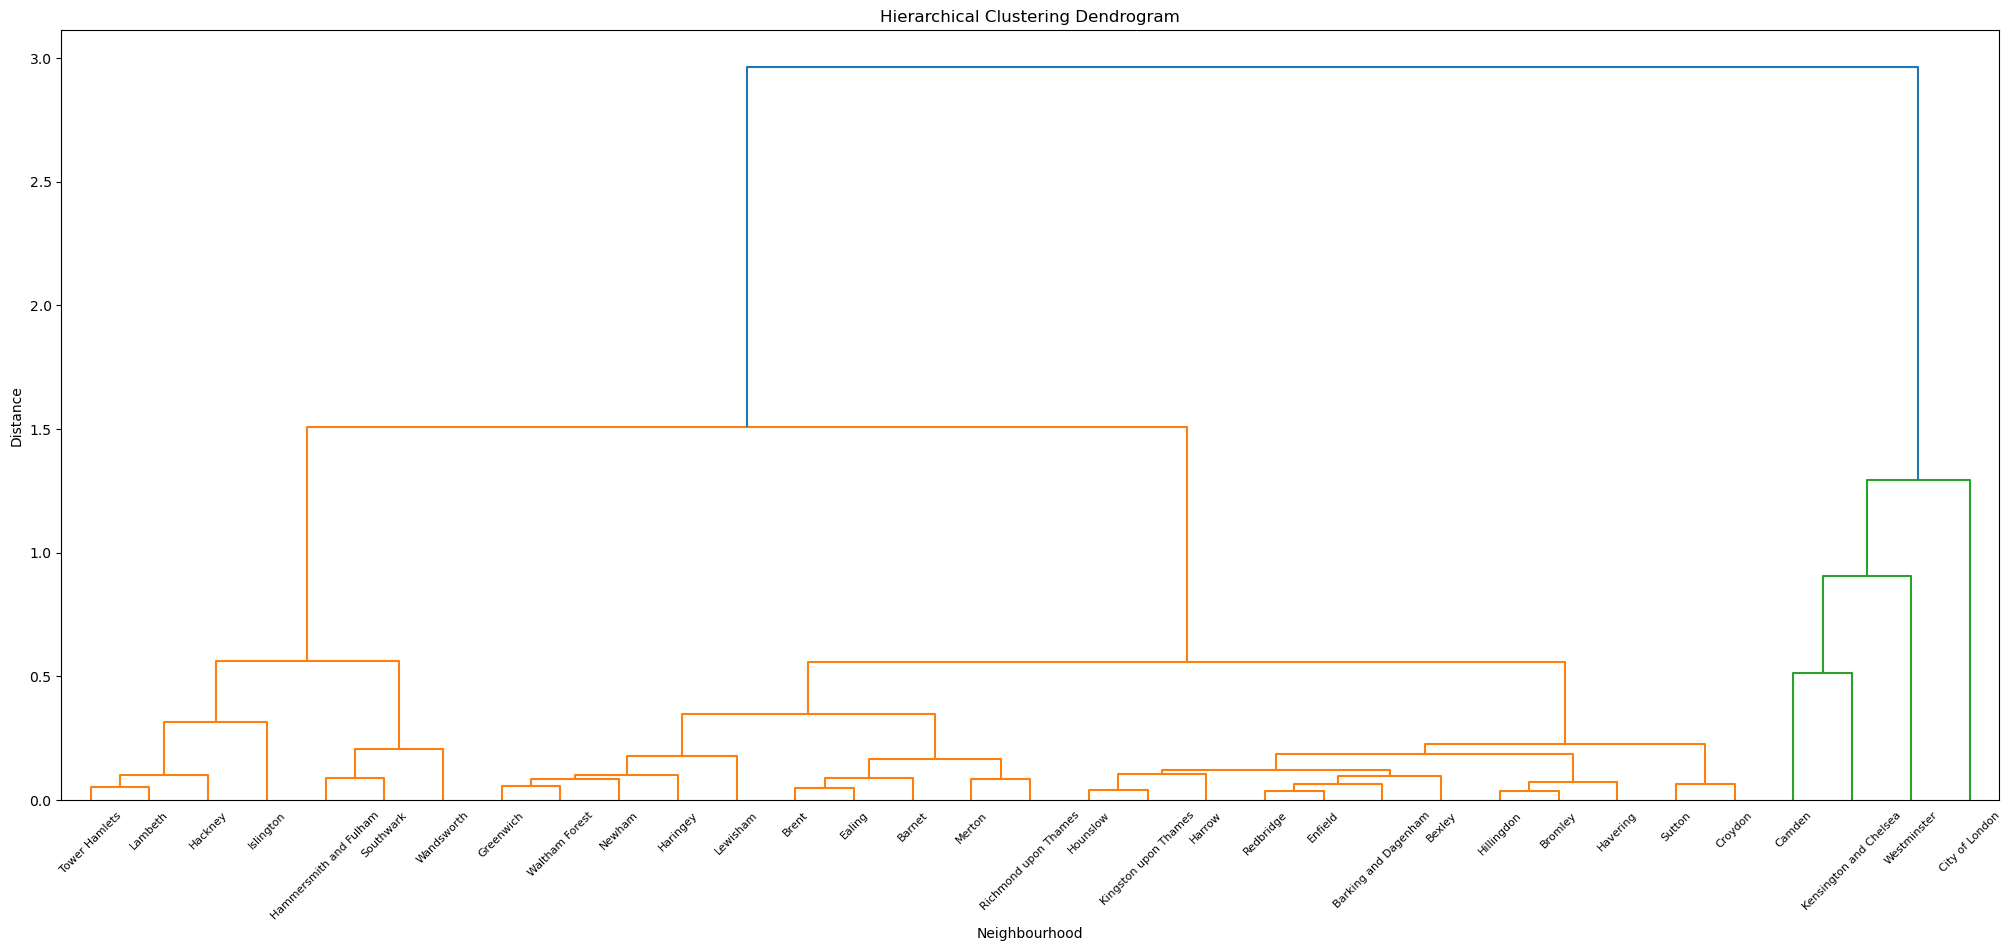

In [95]:
# 使用层次聚类进行聚类
#borough_merge1.set_index('neighbourhood', inplace=True)
linkage_matrix = linkage(borough_merge1[columns_to_calculate], method='ward')

# 绘制树状聚类图
fig, ax = plt.subplots(figsize=(25, 10))
dendrogram(linkage_matrix, labels=borough_merge1.index, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Neighbourhood')
plt.ylabel('Distance')
plt.show()